**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential,model_from_json, Input, Model
from keras.layers.core import Dense, Flatten
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D, Reshape, BatchNormalization
import matplotlib.pyplot as plt

Using TensorFlow backend.


# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self, s, train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

```epsilon``` is the trade-off that needs to be done between exploration and exploitation. The agent needs to explore different states and actions but also need to exploit this exploration by maximizing its Q function. Here the agent acts randomly with probability ```epsilon``` . Without exploration the agent learn.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size + 4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0
        self.scale = 16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))

    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)
    
    def score_max(self):
        return self.board[self.board>0].sum()
    
    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board > 0, 0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[-2:,:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),
                               axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size, self.grid_size)

        malus = -1.0*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train = 100 # set small when debugging
epochs_test= 50 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

The ```board``` array contains the rewards, each time the agent discover a cell, the reward is set to 0. The position ```position``` array contains the information of the agent location on the map: 1 for the current location of the agent, -1 if the cell is the margin and 0 elsewhere.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        """
        A random agent acts randomly.
        """
        return np.random.randint(0, self.n_action, size=1)[0]

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [7]:
def test(agent, env, epochs, prefix='', draw=False):
    # Number of won games
    score = 0
    score_max_total = 0
    for e in range(epochs):
        state = env.reset()
        
        win = 0
        lose = 0
        game_over = False
        score_max = env.score_max()
        score_max_total += score_max
        while not(game_over):
            # The agent performs an random action 
            action = agent.act(state, train=False)
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            # For the test phase, we don't need exploration
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward
             
        # Save as a mp4
        if draw:
            env.draw('clips/'+prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Score Max: {} Average score ({})"
              .format(win, lose, score_max, score/(1+e)))
    print('Final score: '+str(score/epochs))
    return score/epochs, score_max_total/epochs

In [8]:
# Initialize the game
env = Environment(grid_size=size,
                  max_time=T,
                  temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent, env, 50, prefix='random')
HTML(display_videos('clips/random0.mp4'))

Win/lose count 15.0/15.0. Score Max: 47.5 Average score (0.0)
Win/lose count 11.0/7.0. Score Max: 56.5 Average score (2.0)
Win/lose count 10.5/13.0. Score Max: 42.0 Average score (0.5)
Win/lose count 8.5/6.0. Score Max: 40.0 Average score (1.0)
Win/lose count 6.5/8.0. Score Max: 43.0 Average score (0.5)
Win/lose count 8.5/8.0. Score Max: 49.5 Average score (0.5)
Win/lose count 6.0/12.0. Score Max: 47.5 Average score (-0.42857142857142855)
Win/lose count 12.0/14.0. Score Max: 43.0 Average score (-0.625)
Win/lose count 7.0/11.0. Score Max: 42.5 Average score (-1.0)
Win/lose count 9.0/17.0. Score Max: 45.0 Average score (-1.7)
Win/lose count 8.5/19.0. Score Max: 42.0 Average score (-2.5)
Win/lose count 12.5/26.0. Score Max: 38.5 Average score (-3.4166666666666665)
Win/lose count 10.0/15.0. Score Max: 43.5 Average score (-3.5384615384615383)
Win/lose count 6.0/16.0. Score Max: 38.0 Average score (-4.0)
Win/lose count 15.0/5.0. Score Max: 45.5 Average score (-3.066666666666667)
Win/lose cou

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




Let's first define $p_{ss'}^{a} = P(s_{t+1}=s'|a_t=a, s_t=s)$ which is the probability of going from s to s' given the action a,
and $r_{ss'}^a =E[r_{t+1} | s_t=s, s_{t+1}=s', a_t=a]$ which the expected return at time $t+1$ given that action a moved the agent from s to s'.

We have that:
\begin{equation}
 Q^{\pi}(s,a)= E_{\pi}[R_t | s_t=s, a_t=a]
\end{equation}
where $R_t= \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+1}$

\begin{equation*}
\begin{split}
Q^{\pi}(s,a) & = E_{\pi}[\sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+1} | a_t=a, s_t=s] \\
             & = E_{\pi}[ r_{t+1} + \sum\limits_{k=1}^{\infty} \gamma^k ~ r_{k+t+1} | a_t=a, s_t=s]\\
             & = E_{\pi}[ r_{t+1} + \gamma \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+2} | a_t=a, s_t=s]\\
\end{split}
\end{equation*}

$r_{t+1}$ does not depend on $\pi$ because the action a is already chosen.
We can then condition on $s'$ by summing over all possible states:
\begin{equation*}
\begin{split}
Q^{\pi}(s,a) & = E_{\pi}[ r_{t+1} + \gamma \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+2} | a_t=a, s_t=s]\\
             & = \sum\limits_{s'}(p_{ss'}^{a}r_{ss'}^a + \gamma E_{\pi}[ \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+2} | a_t=a, s_t=s, s_{t+1}=s'])\\
             &  = \sum\limits_{s'}(p_{ss'}^{a}r_{ss'}^a + \gamma E_{\pi}[ \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+2} | s_{t+1}=s'])\\
             & = r(s,a) + \gamma\sum\limits_{s'}p_{ss'} E_{\pi}[ \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+2} | s_{t+1}=s']\\
             & = r(s,a) + \gamma \sum\limits_{s'}p_{ss'} E[ \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+2} | s_{t+1}=s', \forall k \geq 1 a_{t+k} = \pi(s_{t+k})])\\
& = r(s,a) + \gamma \sum\limits_{s'}\sum\limits_{a'}p_{ss'} \pi(s') E[ \sum\limits_{k=0}^{\infty} \gamma^k ~ r_{k+t+2} | s_{t+1}=s', \forall k \geq 2 a_{t+k} = \pi(s_{t+k})]\\
& =E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{split}
\end{equation*}



\begin{equation}
\begin{split}
Q^{*}(s,a) & = max_{\pi}  Q(s,a) \\
 &= max_{\pi}( r(s,a) + \gamma \sum\limits_{s'}p_{ss'} Q^{\pi}(s',\pi^*(s')\\
 & = r(s,a) + \gamma \sum\limits_{s'}p_{ss'} max_{\pi} Q^{\pi}(s',\pi^*(s')\\
 &  = r(s,a) + \gamma \sum\limits_{s'}p_{ss'} max_{a'} Q^*(s',a')\\
 & = E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{split}
\end{equation}


The equation for optimality give us this plausible objective because we want that:
$$Q(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q(s',a')]$$.
therefore:
$$E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q(s',a')-Q(s,a)]=0$$

and the L2 norm is a standard way to achieve this.

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [9]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory) < self.max_memory:
            self.memory.append(m)
        else:
            # reassign randomly
            self.memory[np.random.randint(0, len(self.memory), size=1)[0]] = m

    def random_access(self):
        return self.memory[np.random.randint(0, len(self.memory), size=1)[0]]
    
    def __str__(self):
        return 'Memory: {}/{}'.format(len(self.memory),self.max_memory)

***
The pipeline we will use for training is given below:

In [10]:
def train(agent, env, epoch, prefix='', draw=False):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            if draw:
                env.draw('clips/'+prefix+str(e))
            agent.save(name_weights='models/'+prefix+str(e)+'model.h5',
                       name_model='models/'+prefix+str(e)+'model.json')
        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights='models/'+prefix+'model.h5',
                   name_model='models/'+prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [11]:
class DQN(Agent):
    def __init__(self, grid_size, epsilon=0.1, memory_size=100, batch_size=16, n_state=2, **kwargs):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        s = np.expand_dims(s, 0)
        return np.argmax(self.model.predict(s))

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            s_, n_s_, a_, r_, game_over_ = self.memory.random_access()
            input_states[i,:] = s_
            if game_over_:
                target_q[i, a_] = r_
            else:
                target_q[i, a_] = r_ + self.discount*np.max(self.model.predict(np.expand_dims(n_s_, 0)))
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)
        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model


In [12]:
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1, **kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        model = Sequential()
        model.add(Flatten())
        model.add(Dense(kwargs['h_layer_1'], activation='relu'))
        model.add(Dense(self.n_action))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        
        self.model = model
        

In [13]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=0.1, epsilon=0.1, memory_size=2000, batch_size=16, h_layer_1=30)
train(agent, env, epochs_train, prefix='fc_train')

Epoch 000/100 | Loss 0.0167 | Win/lose count 3.0/4.0 (-1.0)
Epoch 001/100 | Loss 0.0039 | Win/lose count 2.5/4.0 (-1.5)
Epoch 002/100 | Loss 0.0084 | Win/lose count 3.0/9.0 (-6.0)
Epoch 003/100 | Loss 0.0137 | Win/lose count 4.0/3.0 (1.0)
Epoch 004/100 | Loss 0.0107 | Win/lose count 10.0/3.0 (7.0)
Epoch 005/100 | Loss 0.0093 | Win/lose count 4.5/3.0 (1.5)
Epoch 006/100 | Loss 0.0028 | Win/lose count 5.0/2.0 (3.0)
Epoch 007/100 | Loss 0.0229 | Win/lose count 3.0/4.0 (-1.0)
Epoch 008/100 | Loss 0.0095 | Win/lose count 6.0/5.0 (1.0)
Epoch 009/100 | Loss 0.0295 | Win/lose count 4.0/3.0 (1.0)
Epoch 010/100 | Loss 0.0036 | Win/lose count 5.5/3.0 (2.5)
Epoch 011/100 | Loss 0.0485 | Win/lose count 6.5/9.0 (-2.5)
Epoch 012/100 | Loss 0.0317 | Win/lose count 8.5/3.0 (5.5)
Epoch 013/100 | Loss 0.0330 | Win/lose count 5.5/6.0 (-0.5)
Epoch 014/100 | Loss 0.0039 | Win/lose count 4.0/3.0 (1.0)
Epoch 015/100 | Loss 0.0029 | Win/lose count 3.0/2.0 (1.0)
Epoch 016/100 | Loss 0.0049 | Win/lose count 2.5/

In [14]:
HTML(display_videos('clips/fc_train90.mp4'))

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [15]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        model = Sequential()
        model.add(Conv2D(kwargs['nb_conv_1'], (2,2), activation="relu"))
        model.add(Conv2D(kwargs['nb_conv_2'], (2,2), activation="relu"))

        model.add(Flatten())
        model.add(Dense(self.n_action))

        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [41]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon=0.1, memory_size=2000, batch_size=16, nb_conv_1=30, nb_conv_2=60)
train(agent, env, epochs_train, prefix='cnn_train')
HTML(display_videos('clips/cnn_train10.mp4'))

Epoch 000/100 | Loss 0.0037 | Win/lose count 3.5/1.0 (2.5)
Epoch 001/100 | Loss 0.0232 | Win/lose count 2.0/4.0 (-2.0)
Epoch 002/100 | Loss 0.0004 | Win/lose count 2.5/5.0 (-2.5)
Epoch 003/100 | Loss 0.0010 | Win/lose count 1.5/2.0 (-0.5)
Epoch 004/100 | Loss 0.0175 | Win/lose count 5.5/4.0 (1.5)
Epoch 005/100 | Loss 0.0035 | Win/lose count 4.0/4.0 (0.0)
Epoch 006/100 | Loss 0.0007 | Win/lose count 6.5/1.0 (5.5)
Epoch 007/100 | Loss 0.0021 | Win/lose count 5.0/1.0 (4.0)
Epoch 008/100 | Loss 0.0008 | Win/lose count 3.0/2.0 (1.0)
Epoch 009/100 | Loss 0.0010 | Win/lose count 5.0/4.0 (1.0)
Epoch 010/100 | Loss 0.0117 | Win/lose count 3.0/4.0 (-1.0)
Epoch 011/100 | Loss 0.0106 | Win/lose count 4.0/2.0 (2.0)
Epoch 012/100 | Loss 0.0042 | Win/lose count 4.0/3.0 (1.0)
Epoch 013/100 | Loss 0.0184 | Win/lose count 4.0/3.0 (1.0)
Epoch 014/100 | Loss 0.0012 | Win/lose count 6.5/7.0 (-0.5)
Epoch 015/100 | Loss 0.0068 | Win/lose count 4.5/2.0 (2.5)
Epoch 016/100 | Loss 0.0011 | Win/lose count 5.0/3.

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [42]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon =0.1, memory_size=2000, batch_size=32, nb_conv_1=30, nb_conv_2=60)
agent_cnn.load(name_weights='models/cnn_trainmodel.h5',name_model='models/cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon=0.1, memory_size=2000, batch_size=32, h_layer_1=30)
agent_fc.load(name_weights='models/fc_trainmodel.h5',name_model='models/fc_trainmodel.json')

print('Test of the CNN')
test(agent_cnn, env, epochs_test, prefix='cnn_test', draw=True)
print('Test of the FC')
test(agent_fc, env, epochs_test, prefix='fc_test', draw=True)

Test of the CNN
Win/lose count 12.5/0. Score Max: 43.5 Average score (12.5)
Win/lose count 12.0/1.0. Score Max: 43.5 Average score (11.75)
Win/lose count 13.5/0. Score Max: 42.5 Average score (12.333333333333334)
Win/lose count 13.5/0. Score Max: 49.0 Average score (12.625)
Win/lose count 9.0/0. Score Max: 38.0 Average score (11.9)
Win/lose count 11.5/3.0. Score Max: 42.5 Average score (11.333333333333334)
Win/lose count 4.0/0. Score Max: 33.5 Average score (10.285714285714286)
Win/lose count 9.0/1.0. Score Max: 45.0 Average score (10.0)
Win/lose count 2.5/0. Score Max: 42.0 Average score (9.166666666666666)
Win/lose count 7.0/2.0. Score Max: 42.0 Average score (8.75)
Win/lose count 5.0/0. Score Max: 51.0 Average score (8.409090909090908)
Win/lose count 4.5/0. Score Max: 43.0 Average score (8.083333333333334)
Win/lose count 13.0/0. Score Max: 43.0 Average score (8.461538461538462)
Win/lose count 3.5/2.0. Score Max: 45.5 Average score (7.964285714285714)
Win/lose count 5.5/0. Score Max:

(1.96, 43.59)

We observe a important issue is the lack of exploration. The agent stays nearby its initial location which hampers the maximation of the reward by not exploring far regions. Setting ```epsilon``` = 0.1 is maybe a bit low.

In [18]:
HTML(display_videos('clips/cnn_test10.mp4'))

In [19]:
HTML(display_videos('clips/fc_test10.mp4'))

#### Influence of the temperature

In [21]:
temperatures = np.linspace(0.1,0.8,8)
scores_test_fc = []
scores_test_max_fc= []

scores_test_cnn = []
scores_test_max_cnn= []

for temperature in temperatures:
    env = Environment(grid_size=size, max_time=T, temperature=temperature)
    score_test, score_max = test(agent_fc, env, 10, prefix='fc_test')
    scores_test_fc.append(score_test)
    scores_test_max_fc.append(score_max)
    score_test, score_max =test(agent_cnn, env, 10, prefix='cnn_test')
    scores_test_cnn.append(score_test)
    scores_test_max_cnn.append(score_max)


Win/lose count 0.5/0. Score Max: 10.0 Average score (0.5)
Win/lose count 1.0/0. Score Max: 14.0 Average score (0.75)
Win/lose count 2.5/0. Score Max: 18.0 Average score (1.3333333333333333)
Win/lose count 0/0. Score Max: 14.5 Average score (1.0)
Win/lose count 0/0. Score Max: 13.0 Average score (0.8)
Win/lose count 1.0/0. Score Max: 14.5 Average score (0.8333333333333334)
Win/lose count 0/0. Score Max: 15.5 Average score (0.7142857142857143)
Win/lose count 0/1.0. Score Max: 11.5 Average score (0.5)
Win/lose count 2.5/0. Score Max: 15.0 Average score (0.7222222222222222)
Win/lose count 1.0/0. Score Max: 15.5 Average score (0.75)
Final score: 0.75
Win/lose count 1.0/0. Score Max: 14.5 Average score (1.0)
Win/lose count 2.0/0. Score Max: 10.5 Average score (1.5)
Win/lose count 2.0/0. Score Max: 13.0 Average score (1.6666666666666667)
Win/lose count 0.5/0. Score Max: 13.5 Average score (1.375)
Win/lose count 1.5/0. Score Max: 12.0 Average score (1.4)
Win/lose count 3.5/1.0. Score Max: 15.5

Win/lose count 2.5/0. Score Max: 101.0 Average score (3.7142857142857144)
Win/lose count 9.5/0. Score Max: 92.5 Average score (4.4375)
Win/lose count 7.0/1.0. Score Max: 99.5 Average score (4.611111111111111)
Win/lose count 2.0/1.0. Score Max: 98.0 Average score (4.25)
Final score: 4.25
Win/lose count 8.5/0. Score Max: 111.0 Average score (8.5)
Win/lose count 18.5/0. Score Max: 100.5 Average score (13.5)
Win/lose count 29.5/2.0. Score Max: 105.5 Average score (18.166666666666668)
Win/lose count 10.5/1.0. Score Max: 99.0 Average score (16.0)
Win/lose count 25.0/3.0. Score Max: 105.0 Average score (17.2)
Win/lose count 37.0/1.0. Score Max: 98.0 Average score (20.333333333333332)
Win/lose count 49.0/0. Score Max: 108.0 Average score (24.428571428571427)
Win/lose count 15.5/0. Score Max: 108.0 Average score (23.3125)
Win/lose count 16.5/0. Score Max: 104.0 Average score (22.555555555555557)
Win/lose count 22.0/1.0. Score Max: 100.0 Average score (22.4)
Final score: 22.4
Win/lose count 5.0/

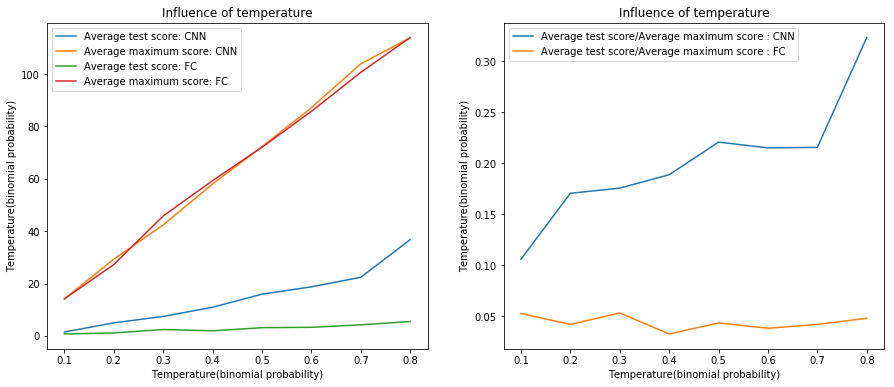

In [32]:
scores_test_cnn = np.array(scores_test_cnn)
scores_test_fc = np.array(scores_test_fc)
scores_test_max_fc = np.array(scores_test_max_fc)
scores_test_max_cnn = np.array(scores_test_max_cnn)


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(temperatures, scores_test_cnn, label='Average test score: CNN')
plt.plot(temperatures, scores_test_max_cnn, label='Average maximum score: CNN')

plt.plot(temperatures, scores_test_fc, label='Average test score: FC')
plt.plot(temperatures, scores_test_max_fc, label='Average maximum score: FC')

plt.title('Influence of temperature')
plt.xlabel('Temperature(binomial probability)')
plt.ylabel('Temperature(binomial probability)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(temperatures, scores_test_cnn/scores_test_max_cnn, label='Average test score/Average maximum score : CNN')

plt.plot(temperatures, scores_test_fc/scores_test_max_fc, label='Average test score/Average maximum score : FC')

plt.title('Influence of temperature')
plt.xlabel('Temperature(binomial probability)')
plt.ylabel('Temperature(binomial probability)')
plt.legend()

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [33]:
def train_explore(agent, env, epoch, epsilon_min, epsilon_max, epsilon_epoch, decay, prefix=''):
    # Number of won games
    score = 0
    loss = 0
    epsilons = np.linspace(epsilon_max, epsilon_min, epsilon_epoch)
    for c, e in enumerate(range(epoch)):
        if c < len(epsilons):
            agent.set_epsilon(epsilons[c])
            print('Setting epsilon: {0:.2f}'.format(agent.epsilon))

        epsilon = agent.epsilon*(1-decay)
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=True)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
            
        # Save as a mp4
        if e % 10 == 0:
            agent.save(name_weights='models/'+prefix+str(e)+'model.h5',
                       name_model='models/'+prefix+str(e)+'model.json')
        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        #print(agent.memory)
    agent.save(name_weights='models/'+prefix+'model.h5',
                   name_model='models/'+prefix+'model.json')

In [34]:
class EnvironmentExploring(Environment):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1, malus_explored=-0.1):
        super(EnvironmentExploring, self).__init__(grid_size, max_time, temperature)
        # add structure for the map of explored cells
        self.explored = np.zeros((self.grid_size, self.grid_size))
        # setting malus explored value
        self.malus_explored = malus_explored
        
    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[-2:,:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        if train:
            # when training penalise reward for explored cells
            reward = self.board[self.x, self.y] + self.explored[self.x, self.y]
        else:
            reward = self.board[self.x, self.y]

        self.board[self.x, self.y] = 0
        
        # adding explored cells penalty
        self.explored[self.x, self.y] = self.malus_explored
        
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1),
                                self.explored.reshape(self.grid_size, self.grid_size,1)
                               ),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size, self.grid_size)

        malus = -1.0*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus
        #reset explore map to zero
        self.explored = np.zeros((self.grid_size, self.grid_size))
        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size, 1),
                                self.position.reshape(self.grid_size, self.grid_size, 1),
                                self.explored.reshape(self.grid_size, self.grid_size, 1)),
                               axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state
    

In [35]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3, malus_explored=-0.1)
agent = DQN_CNN(size, lr=.1, epsilon=0.4, memory_size=2000, batch_size=16, n_state=3, nb_conv_1=30, nb_conv_2=60)
train_explore(agent, env,  100, prefix='cnn_train_explore', epsilon_min=0.1, epsilon_max=0.4, epsilon_epoch=30, decay=0.1)
HTML(display_videos('clips/cnn_train_explore10.mp4'))

Setting epsilon: 0.40
Epoch 000/100 | Loss 0.0384 | Win/lose count 12.5/32.00000000000007 (-19.50000000000007)
Setting epsilon: 0.39
Epoch 001/100 | Loss 0.0234 | Win/lose count 12.0/23.400000000000052 (-11.400000000000052)
Setting epsilon: 0.38
Epoch 002/100 | Loss 0.0238 | Win/lose count 18.0/22.00000000000004 (-4.000000000000039)
Setting epsilon: 0.37
Epoch 003/100 | Loss 0.0148 | Win/lose count 15.0/22.000000000000025 (-7.000000000000025)
Setting epsilon: 0.36
Epoch 004/100 | Loss 0.0212 | Win/lose count 13.5/23.700000000000056 (-10.200000000000056)
Setting epsilon: 0.35
Epoch 005/100 | Loss 0.0261 | Win/lose count 17.5/26.300000000000082 (-8.800000000000082)
Setting epsilon: 0.34
Epoch 006/100 | Loss 0.0084 | Win/lose count 16.5/19.000000000000007 (-2.500000000000007)
Setting epsilon: 0.33
Epoch 007/100 | Loss 0.0140 | Win/lose count 21.0/18.90000000000001 (2.0999999999999908)
Setting epsilon: 0.32
Epoch 008/100 | Loss 0.0260 | Win/lose count 21.5/18.199999999999992 (3.30000000000

Epoch 085/100 | Loss 0.0155 | Win/lose count 27.5/15.499999999999977 (12.000000000000023)
Epoch 086/100 | Loss 0.0328 | Win/lose count 25.0/14.699999999999982 (10.300000000000018)
Epoch 087/100 | Loss 0.0656 | Win/lose count 25.5/18.1 (7.399999999999999)
Epoch 088/100 | Loss 0.0616 | Win/lose count 17.0/15.499999999999968 (1.500000000000032)
Epoch 089/100 | Loss 0.0196 | Win/lose count 17.0/20.50000000000002 (-3.5000000000000213)
Epoch 090/100 | Loss 0.0308 | Win/lose count 23.0/20.200000000000024 (2.799999999999976)
Epoch 091/100 | Loss 0.0144 | Win/lose count 11.0/17.699999999999985 (-6.699999999999985)
Epoch 092/100 | Loss 0.0265 | Win/lose count 18.5/25.000000000000014 (-6.500000000000014)
Epoch 093/100 | Loss 0.0242 | Win/lose count 19.5/14.999999999999966 (4.500000000000034)
Epoch 094/100 | Loss 0.0192 | Win/lose count 19.5/19.500000000000025 (-2.4868995751603507e-14)
Epoch 095/100 | Loss 0.0112 | Win/lose count 18.5/15.09999999999997 (3.4000000000000306)
Epoch 096/100 | Loss 0.0

In [36]:
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32, nb_conv_1=30, nb_conv_2=60)
agent.load(name_weights='models/cnn_train_exploremodel.h5',name_model='models/cnn_train_exploremodel.json')
# Evaluation
test(agent, env, epochs_test, prefix='cnn_test_explore', draw=True)


Win/lose count 25.0/7.0. Score Max: 46.5 Average score (18.0)
Win/lose count 23.5/1.0. Score Max: 46.5 Average score (20.25)
Win/lose count 17.5/3.0. Score Max: 38.5 Average score (18.333333333333332)
Win/lose count 13.5/1.0. Score Max: 42.0 Average score (16.875)
Win/lose count 5.0/3.0. Score Max: 40.0 Average score (13.9)
Win/lose count 17.5/3.0. Score Max: 46.0 Average score (14.0)
Win/lose count 17.0/2.0. Score Max: 39.5 Average score (14.142857142857142)
Win/lose count 14.5/2.0. Score Max: 45.5 Average score (13.9375)
Win/lose count 10.0/2.0. Score Max: 43.5 Average score (13.277777777777779)
Win/lose count 23.0/4.0. Score Max: 41.0 Average score (13.85)
Win/lose count 16.0/4.0. Score Max: 42.5 Average score (13.681818181818182)
Win/lose count 18.0/5.0. Score Max: 39.5 Average score (13.625)
Win/lose count 19.5/2.0. Score Max: 45.5 Average score (13.923076923076923)
Win/lose count 20.0/2.0. Score Max: 40.0 Average score (14.214285714285714)
Win/lose count 21.5/1.0. Score Max: 39.5

(13.45, 43.24)

In [40]:
HTML(display_videos('clips/cnn_test_explore40.mp4'))

We observe that the agent exploration has improved test score (x2) thanks to both techniques we have implemented. However, the agent stays still blocked on some games because he is surrounded by empty and explored cells and its limited information(5x5) around him prevents from exploring further regions.

***